###0._Memoria. Guardando imagenes... 

In [ ]:
#GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Apr  8 04:09:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###1._Carga del conjunto de datos
###Kaggle data.
https://www.kaggle.com/datasets/alchzamb/monusacdata

In [ ]:
#Preparando el dataset.
!pip install --upgrade --force-reinstall --no-deps kaggle
#%%capture
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()

# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 58 kB 5.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=9b1a3356179ae3db7f241184043915b010dd3b094866144db46f5e8a0f85ac82
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Saving kaggle.json to kaggle.json


In [ ]:
#MoNuSAC Test Data and Annotations
#https://www.kaggle.com/datasets/alchzamb/monusacdata
!kaggle datasets download -d alchzamb/monusacdata

100% 715M/715M [00:13<00:00, 57.7MB/s]
100% 715M/715M [00:13<00:00, 56.1MB/s]


In [ ]:
%%capture
#unzip -d target_directory zip_file
!unzip -d '/content/monusac/' monusacdata.zip

In [ ]:
#organ path (pulmó, riñón, pecho, próstata).
path_lung = '/content/monusac/MoNuSAC_images_and_annotations/MoNuSAC_images_and_annotations/TCGA-55-1594-01Z-00-DX1'
path_kidney = '/content/monusac/MoNuSAC_images_and_annotations/MoNuSAC_images_and_annotations/TCGA-5P-A9K0-01Z-00-DX1'
path_breast = '/content/monusac/MoNuSAC_images_and_annotations/MoNuSAC_images_and_annotations/TCGA-A2-A0CV-01Z-00-DX1'
path_prostate = '/content/monusac/MoNuSAC_images_and_annotations/MoNuSAC_images_and_annotations/TCGA-EJ-5495-01Z-00-DX1'

In [ ]:
#librerias
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import matplotlib.image as mpimg
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

import numpy as np
from keras.models import Sequential
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout
import matplotlib.pyplot as plt
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [ ]:
#creando el set de entrenamiento.
def my_set(path, size, SPATIAL_DIM):
  X = np.empty(shape=(size, SPATIAL_DIM, SPATIAL_DIM, 3))
  i = 0
  for directory_path in glob.glob(path):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
      img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
      img = cv2.resize(img, (SPATIAL_DIM, SPATIAL_DIM))
      img = img_to_array(img)
      img = img[:,:,:-1]
      X[i] = img
      i += 1
  print('Set.shape:',X.shape)
  return X

In [ ]:
print('lung.shape:')
lung = my_set(path_lung, size=5, SPATIAL_DIM=128)
print('kidney.shape:')
kidney = my_set(path_kidney, size=3, SPATIAL_DIM=128)
print('breast.shape:')
breast = my_set(path_breast, size=5, SPATIAL_DIM=128)
print('prostate.shape:')
prostate = my_set(path_prostate, size=4, SPATIAL_DIM=128)

lung.shape:
Set.shape: (5, 128, 128, 3)
kidney.shape:
Set.shape: (3, 128, 128, 3)
breast.shape:
Set.shape: (5, 128, 128, 3)
prostate.shape:
Set.shape: (4, 128, 128, 3)


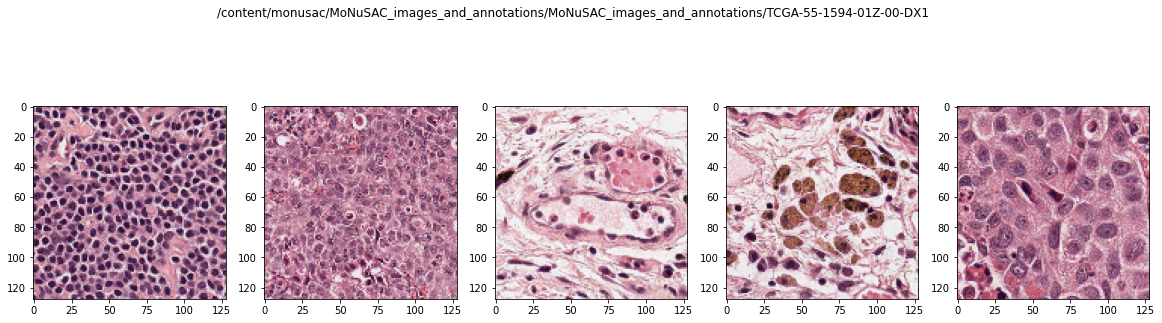

In [ ]:
from google.colab import output
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(lung):
    plt.subplot(len(lung) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    plt.suptitle(path_lung)
    output.clear()

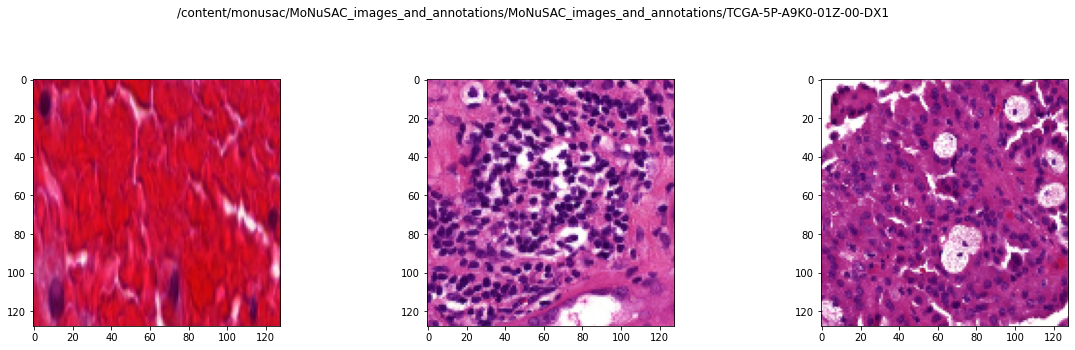

In [ ]:
from google.colab import output
plt.figure(figsize=(20,10))
columns = 3
for i, image in enumerate(kidney):
    plt.subplot(len(kidney) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    plt.suptitle(path_kidney)
    output.clear()

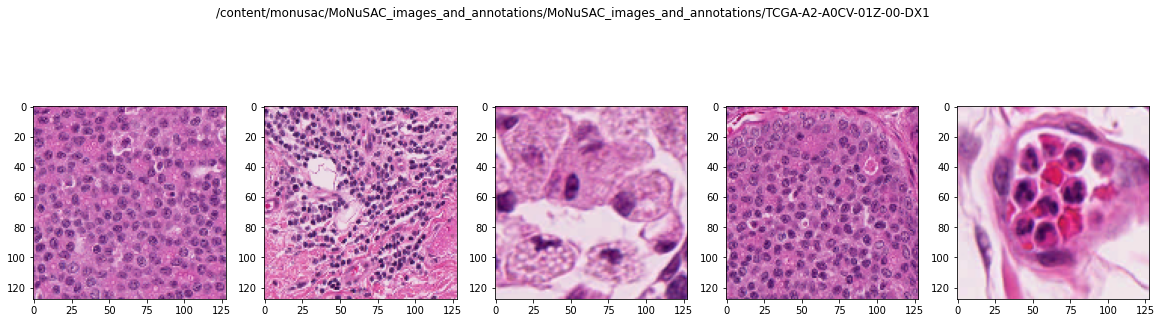

In [ ]:
from google.colab import output
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(breast):
    plt.subplot(len(breast) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    plt.suptitle(path_breast)
    output.clear()

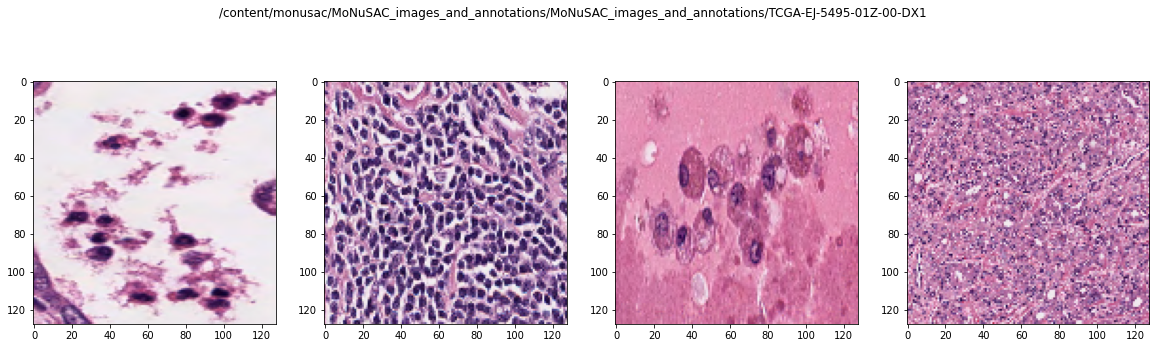

In [ ]:
from google.colab import output
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(prostate):
    plt.subplot(len(prostate) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    plt.suptitle(path_prostate)
    output.clear()

In [ ]:
from google.colab import files
files.upload()

Saving translator.h5 to translator.h5


In [ ]:
from google.colab import files
files.upload()

In [ ]:
# install keras.contrib with the InstanceNormalization layer
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-5j6b5vja
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-5j6b5vja
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=326d5c2398cc777637f32e0e6d08e01d2943d574f1ee7be91b447be3bc2b3175
  Stored in directory: /tmp/pip-ephem-wheel-cache-o1wf5u40/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
# import the new instance normalization layer
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [ ]:
from keras.models import load_model
from keras_contrib.layers import GroupNormalization
# Load our model
custom_objects = {'InstanceNormalization': InstanceNormalization, 'GroupNormalization': GroupNormalization}


#modelos:
translatorAtoB = load_model('/content/translator.h5', custom_objects)
#translatorBtoA = load_model('/content/translatorBtoA.h5', custom_objects)


#Recupera el estado del modelo.
#weights = unet.get_weights()
#mira: https://github.com/fizyr/keras-retinanet/issues/748

In [ ]:
# Generate predictions for samples
predictions_lung = translatorAtoB.predict(lung)
print('predictions_lung.shape:', predictions_lung.shape)
predictions_kidney = translatorAtoB.predict(kidney)
print('predictions_kidney.shape:', predictions_kidney.shape)
predictions_breast = translatorAtoB.predict(breast)
print('predictions_breast.shape:', predictions_breast.shape)
predictions_prostate = translatorAtoB.predict(prostate)
print('predictions_prostate.shape:', predictions_prostate.shape)

predictions_lung.shape: (5, 128, 128, 3)
predictions_kidney.shape: (3, 128, 128, 3)
predictions_breast.shape: (5, 128, 128, 3)
predictions_prostate.shape: (4, 128, 128, 3)


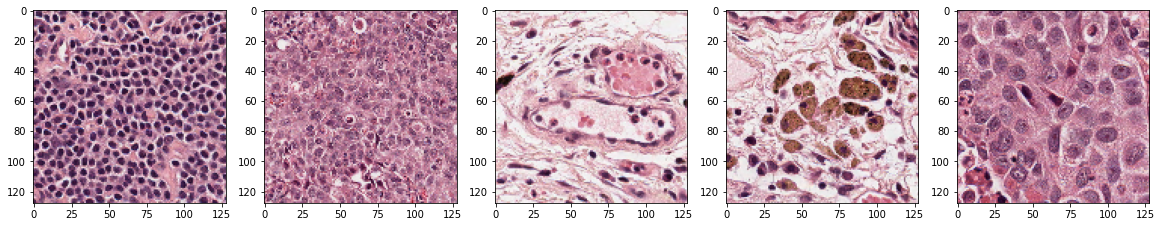

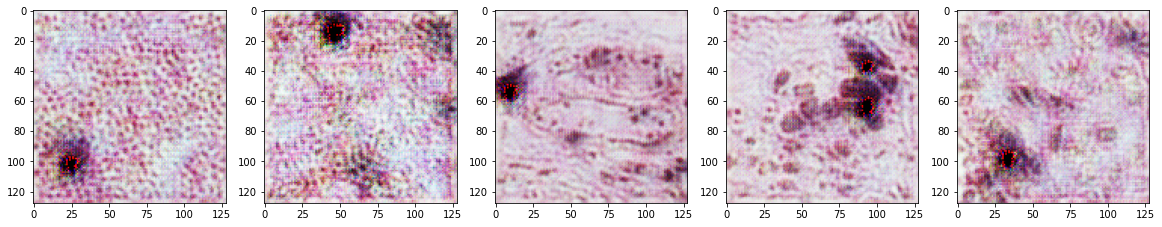

In [ ]:
from google.colab import output
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(lung):
    plt.subplot(len(lung) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    #plt.suptitle(path_lung)
    output.clear()
from google.colab import output
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(predictions_lung):
    plt.subplot(len(predictions_lung) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    #plt.suptitle(path_lung)
    output.clear()

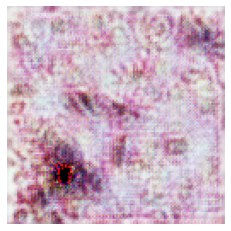

In [ ]:
for i, image in enumerate(predictions_lung):
  plt.axis('off')
  filename = '%01d_predictions_lung_image_.png' % (i+1)
  plt.imshow(array_to_img(predictions_lung[i]))
  plt.savefig(filename, bbox_inches='tight', pad_inches=0.001)

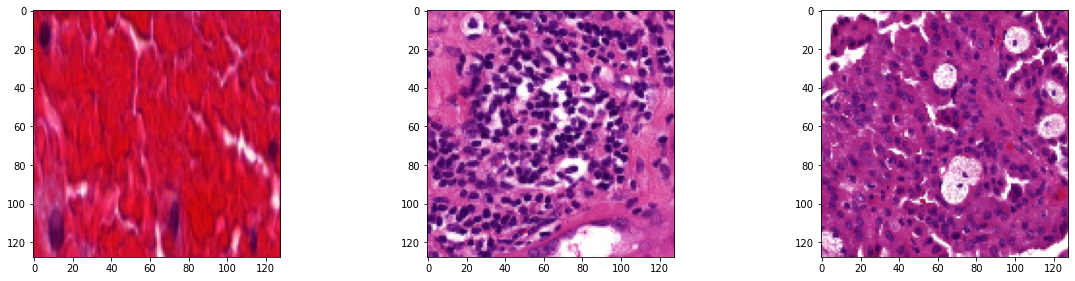

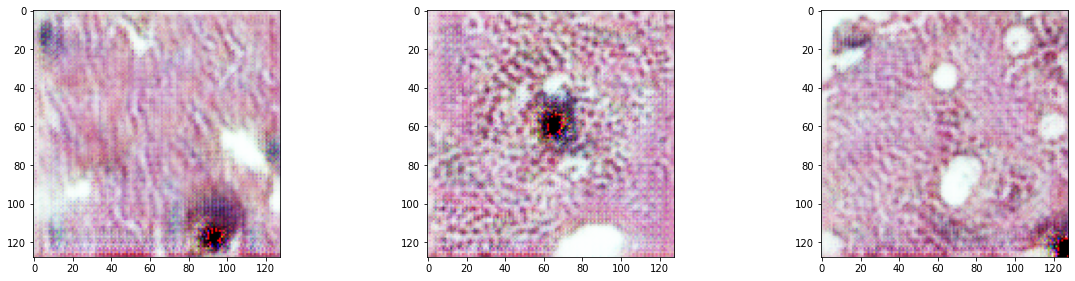

In [ ]:
from google.colab import output
plt.figure(figsize=(20,10))
columns = 3
for i, image in enumerate(kidney):
    plt.subplot(len(kidney) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    #plt.suptitle(path_kidney)
    output.clear()
from google.colab import output
plt.figure(figsize=(20,10))
columns = 3
for i, image in enumerate(predictions_kidney):
    plt.subplot(len(predictions_kidney) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    #plt.suptitle(path_kidney)
    output.clear()

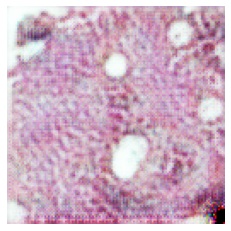

In [ ]:
for i, image in enumerate(predictions_kidney):
  plt.axis('off')
  filename = '%01d_predictions_kidney_image_.png' % (i+1)
  plt.imshow(array_to_img(predictions_kidney[i]))
  plt.savefig(filename, bbox_inches='tight', pad_inches=0.001)

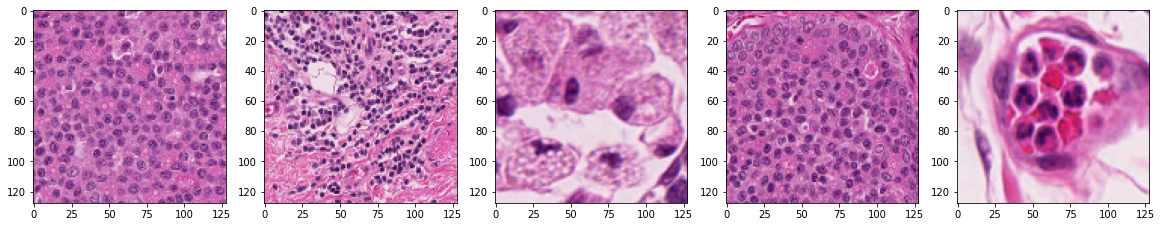

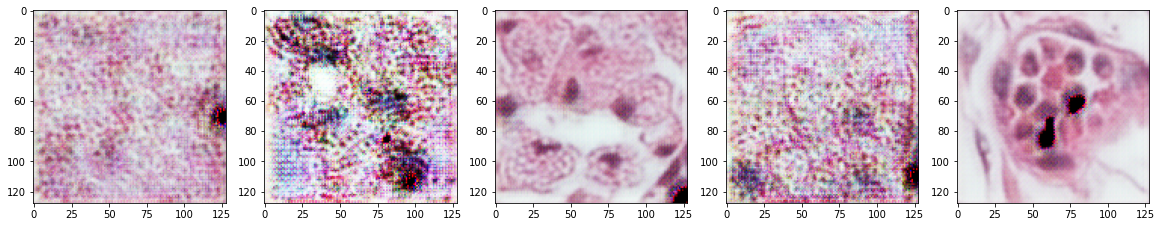

In [ ]:
from google.colab import output
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(breast):
    plt.subplot(len(breast) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    #plt.suptitle(path_breast)
    output.clear()
from google.colab import output
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(predictions_breast):
    plt.subplot(len(predictions_breast) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    #plt.suptitle(path_breast)
    output.clear()

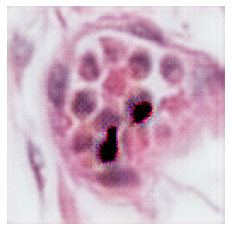

In [ ]:
for i, image in enumerate(predictions_breast):
  plt.axis('off')
  filename = '%01d_predictions_breast_image_.png' % (i+1)
  plt.imshow(array_to_img(predictions_breast[i]))
  plt.savefig(filename, bbox_inches='tight', pad_inches=0.001)

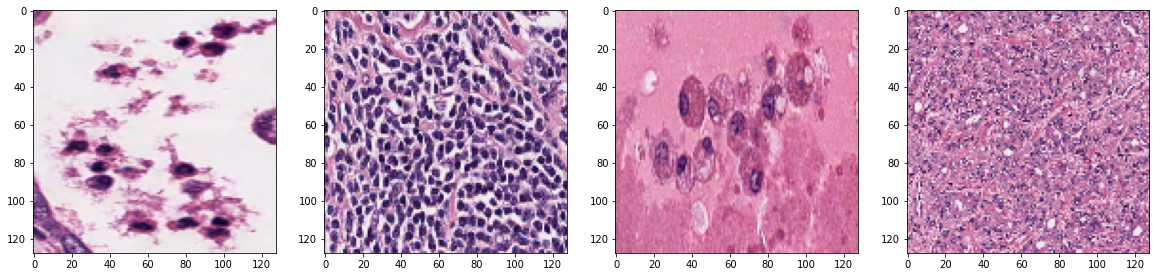

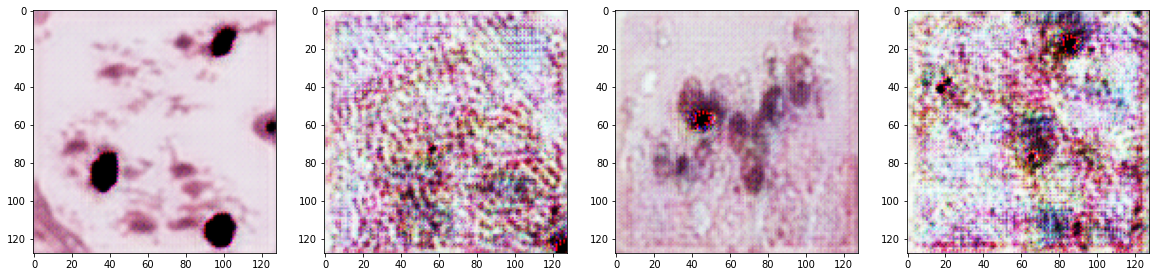

In [ ]:
from google.colab import output
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(prostate):
    plt.subplot(len(prostate) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    #plt.suptitle(path_prostate)
    output.clear()
from google.colab import output
plt.figure(figsize=(20,10))
columns = 4
for i, image in enumerate(predictions_prostate):
    plt.subplot(len(predictions_prostate) / columns + 1, columns, i + 1)
    #plt.axis('off') 
    plt.imshow(array_to_img(image))
    #plt.suptitle(path_prostate)
    output.clear()

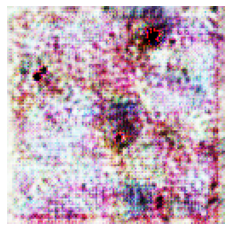

In [ ]:
for i, image in enumerate(predictions_prostate):
  plt.axis('off')
  filename = '%01d_predictions_prostate_image_.png' % (i+1)
  plt.imshow(array_to_img(predictions_prostate[i]))
  plt.savefig(filename, bbox_inches='tight', pad_inches=0.001)